In [1]:
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
import numpy as np
import flax.linen as nn
from typing import Any, List
import dataclasses
import distrax

Array = Any

%load_ext autoreload
%autoreload 2


In [2]:
tfd = tfp.distributions
tfb = tfp.bijectors

In [3]:
import sys
sys.path.append("../")

In [4]:
from modules.autoregressive import MADE, MAF

made = MADE(n_params=5, n_context=0, activation="tanh", hidden_dims=[32, 32], name="made_0")
key = jax.random.PRNGKey(2)
x = jax.random.uniform(key=key, shape=(3, 4, 5))
init_params = made.init(key, x)

bijector_fn = lambda x: made.apply(init_params, x)

flow = MAF(bijector_fn, unroll_loop=False)

base_dist = distrax.MultivariateNormalDiag(jnp.zeros(5,), jnp.ones(5,))

distrax.Transformed(base_dist, flow).log_prob(x), distrax.Transformed(base_dist, flow).sample(seed=key)

(Array([[-5.4595404, -5.5994473, -5.9427986, -5.759067 ],
        [-5.902549 , -5.0206127, -5.299887 , -5.0263357],
        [-5.473523 , -5.161093 , -5.683456 , -5.1374702]], dtype=float32),
 Array([-0.15508525,  1.5708686 , -0.6395317 ,  0.20873874, -0.37311628],      dtype=float32))

In [5]:
y, log_det = flow.forward_and_log_det(x)
print(log_det)

[[ 0.38752255  0.32605276  0.32989642  0.07925294]
 [ 0.24268195  0.22704002  0.0395263   0.0467682 ]
 [ 0.48092732  0.02677736 -0.07056034  0.03673583]]


In [6]:
y, log_det = flow.inverse_and_log_det(y)
print(log_det)

[[-0.38752255 -0.32605276 -0.32989642 -0.07925294]
 [-0.24268195 -0.22704002 -0.0395263  -0.0467682 ]
 [-0.48092732 -0.02677736  0.07056034 -0.03673583]]


In [7]:
class MaskedAutoregressiveFlow(nn.Module):
    n_dim: int
    n_context: int = 0
    n_transforms: int = 4
    hidden_dims: List[int] = dataclasses.field(default_factory=lambda: [32, 32])
    activation: str = "relu"
    unroll_loop: bool = False
    use_random_permutations: bool = True
    rng_key: jnp.ndarray = jax.random.PRNGKey(0)
    inverse: bool = False

    def setup(self):

        self.made = [MADE(n_params=self.n_dim, n_context=self.n_context, activation=self.activation, hidden_dims=self.hidden_dims, name="made_{}".format(i)) for i in range(self.n_transforms)]

        bijectors = []
        key = self.rng_key
        for i in range(self.n_transforms):
            if self.use_random_permutations:
                bijectors.append(tfb.Permute(jax.random.choice(key, jnp.arange(self.n_dim), shape=(self.n_dim,), replace=False)))
                key, _ = jax.random.split(key)
            else:
                bijectors.append(tfb.Permute(list(reversed(range(self.n_dim)))))
            bijectors.append(MAF(bijector_fn=self.made[i], unroll_loop=self.unroll_loop))
        
        if self.inverse:
            self.bijector = distrax.Chain(bijectors)
        else:
            self.bijector = distrax.Inverse(distrax.Chain(bijectors))

    def make_flow_model(self):

        flow = self.bijector
        base_dist = distrax.MultivariateNormalDiag(jnp.zeros(self.n_dim), jnp.ones(self.n_dim))

        return flow, base_dist

    def __call__(self, x: jnp.array) -> jnp.array:
        flow, base_dist = self.make_flow_model()
        return distrax.Transformed(base_dist, flow).log_prob(x)

    def sample(self, num_samples, rng) -> jnp.array:
        flow, base_dist = self.make_flow_model()
        return distrax.Transformed(base_dist, flow).sample(seed=rng, sample_shape=(num_samples))

In [8]:
maf = MaskedAutoregressiveFlow(n_dim=5, unroll_loop=True)

key = jax.random.PRNGKey(2)
x = jax.random.uniform(key=key, shape=(3, 5))
params = maf.init(key, x)

## Test flow

In [9]:
import optax
import matplotlib.pyplot as plt
from PIL import Image

In [10]:
image = Image.open('../data/iaifi-logo-black-noborder-hires.jpeg').convert('L')
data = np.asarray(image)

In [11]:
dist_true = ~data[::-1]
dist_true = dist_true / np.sum(dist_true)

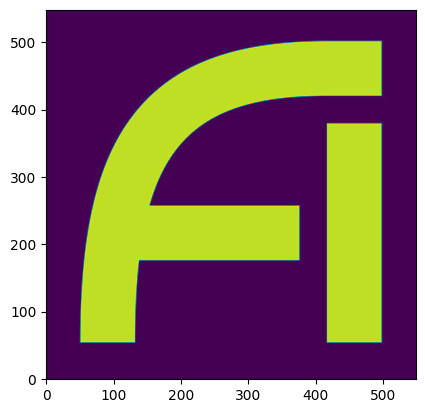

In [12]:
plt.imshow(dist_true, origin='lower')

In [13]:
pairs = np.indices(dimensions=dist_true.shape).T

n = 5000
inds=np.random.choice(np.arange(np.prod(dist_true.shape)),p=dist_true.reshape(-1),size=n,replace=True)

selections = pairs.reshape(-1,2)[inds].astype(np.float32)
selections_std = selections.std()
selections_mean = selections.mean()


In [14]:
selections = (selections - selections_mean) / selections_std

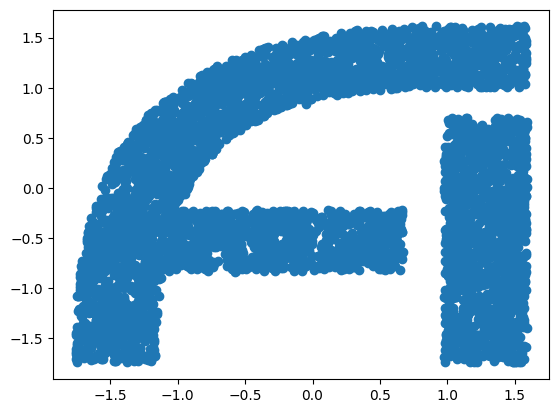

In [15]:
plt.scatter(*selections.T)


In [29]:
n_dim = 2
model = MaskedAutoregressiveFlow(n_dim=n_dim, n_transforms=8, activation="relu", unroll_loop=True, use_random_permutations=False)

key = jax.random.PRNGKey(0)
x = jax.random.uniform(key=key, shape=(8, n_dim))
params = model.init(key, x)

In [30]:
model.apply(params, jnp.array(selections));

In [31]:
optimizer = optax.adamw(learning_rate=3e-4, weight_decay=1e-5)
opt_state = optimizer.init(params)

@jax.jit
def loss_fn(params, batch):
  loss = -jnp.mean(model.apply(params, batch))
  return loss

@jax.jit
def update(params, opt_state, batch):
  grads = jax.grad(loss_fn)(params, batch)
  updates, new_opt_state = optimizer.update(grads, opt_state, params)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state


In [32]:
from tqdm import tqdm

batch_size = 64
n_steps = 30000

for step in tqdm(range(n_steps)):
    batch = jnp.array(selections)[np.random.choice(np.arange(len(selections)), size=batch_size, replace=False)]
    params, opt_state = update(params, opt_state, batch)


100%|██████████| 30000/30000 [00:33<00:00, 891.23it/s] 


(-3.0, 3.0)

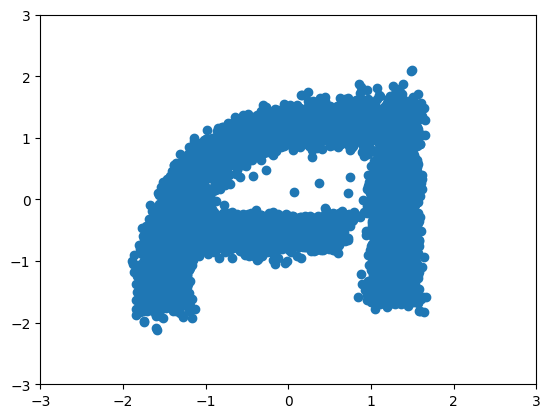

In [33]:
def eval_model(model):
    samples = model.sample(num_samples=5000, rng=key)
    return samples

samples = nn.apply(eval_model, model)(params)
plt.scatter(*samples.T)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
